In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider, Dropdown
plt.ion()

# Ipywidgets

In [2]:
data = np.logspace(0, 2, 100)
data = np.tile(data, [100, 1])
data += np.random.randn(100, 100) * 50
data += np.linspace(0, 1000, 100)[:, np.newaxis]

In [3]:
cmaps = ['coolwarm', 'viridis', 'magma']
def plot_data(ii, cmap):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap(cmap)
    color = cmap(ii / 100.)
    ax.plot(data[ii], color=color)
    ax.set_ylim([0, 1000])
    plt.show()
    
p = interact(plot_data, ii=IntSlider(0, 0, 99), cmap=Dropdown(options=cmaps))

interactive(children=(IntSlider(value=0, description='ii', max=99), Dropdown(description='cmap', options=('coo…

In [6]:
from netCDF4 import Dataset
dataset = Dataset('tas_Amon_MPI-ESM-LR_rcp26_r1i1p1_200601-210012.nc')
print(dataset.variables['tas'])

<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    cell_methods: time: mean
    cell_measures: area: areacella
    history: 2011-07-17T14:58:52Z altered by CMOR: Treated scalar dimension: 'height'.
    coordinates: height
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_MPI-ESM-LR_rcp26_r0i0p0.nc areacella: areacella_fx_MPI-ESM-LR_rcp26_r0i0p0.nc
unlimited dimensions: time
current shape = (1140, 96, 192)
filling on


In [16]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [24]:
ds = xr.tutorial.load_dataset('air_temperature')
ds = xr.load_dataset('tas_Amon_MPI-ESM-LR_rcp26_r1i1p1_200601-210012.nc')

AttributeError: 'GeoAxesSubplot' object has no attribute 'borders'

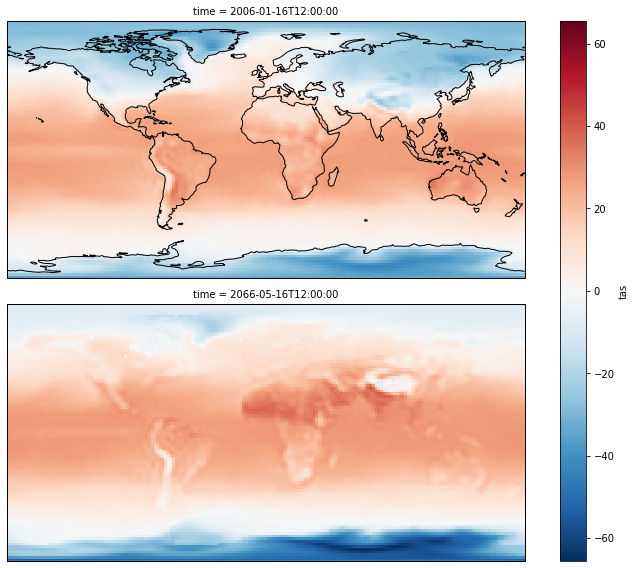

In [54]:
air = ds.tas.isel(time=[0, 724]) - 273.15

# This is the map projection we want to plot *onto*
#map_proj = ccrs.PlateCarree(central_longitude=-95, central_latitude=45)
map_proj = ccrs.PlateCarree(central_longitude=0.0, globe=None)
p = air.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='time', col_wrap=1,  # multiplot settings
             aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj}, figsize=(10, 8))  # the plot's projection


# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([20, 60, -20, 10])



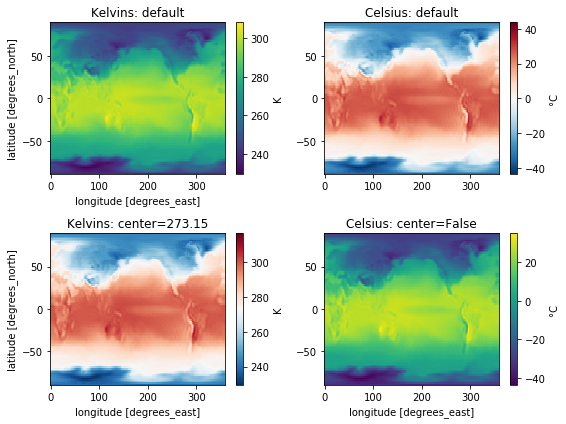

In [31]:
air = ds.tas.isel(time=0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

# The first plot (in kelvins) chooses "viridis" and uses the data's min/max
air.plot(ax=ax1, cbar_kwargs={'label': 'K'})
ax1.set_title('Kelvins: default')
ax2.set_xlabel('')

# The second plot (in celsius) now chooses "BuRd" and centers min/max around 0
airc = air - 273.15
airc.plot(ax=ax2, cbar_kwargs={'label': '°C'})
ax2.set_title('Celsius: default')
ax2.set_xlabel('')
ax2.set_ylabel('')

# The center doesn't have to be 0
air.plot(ax=ax3, center=273.15, cbar_kwargs={'label': 'K'})
ax3.set_title('Kelvins: center=273.15')

# Or it can be ignored
airc.plot(ax=ax4, center=False, cbar_kwargs={'label': '°C'})
ax4.set_title('Celsius: center=False')
ax4.set_ylabel('')

# Make it nice
plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


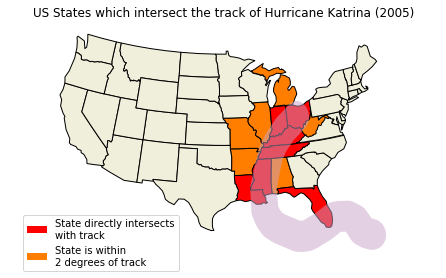

In [55]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader


def sample_data():
    """
    Returns a list of latitudes and a list of longitudes (lons, lats)
    for Hurricane Katrina (2005).

    The data was originally sourced from the HURDAT2 dataset from AOML/NOAA:
    http://www.aoml.noaa.gov/hrd/hurdat/newhurdat-all.html on 14th Dec 2012.

    """
    lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0,
            -79.6, -80.1, -80.3, -81.3, -82.0, -82.6, -83.3, -84.0,
            -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, -89.2, -89.6,
            -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0,
            -85.3, -82.9]

    lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0,
            25.9, 25.4, 25.1, 24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2,
            25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 30.2, 31.1, 32.6, 34.1,
            35.6, 37.0, 38.6, 40.1]

    return lons, lats


def main():
    ax = plt.axes([0, 0, 1, 1],
                  projection=ccrs.LambertConformal())

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    lons, lats = sample_data()

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    plt.title('US States which intersect the track '
              'of Hurricane Katrina (2005)')

    # turn the lons and lats into a shapely LineString
    track = sgeom.LineString(zip(lons, lats))

    # buffer the linestring by two degrees (note: this is a non-physical
    # distance)
    track_buffer = track.buffer(2)

    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = [0.9375, 0.9375, 0.859375]
        edgecolor = 'black'

        if state.intersects(track):
            facecolor = 'red'
        elif state.intersects(track_buffer):
            facecolor = '#FF7E00'

        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor)

    ax.add_geometries([track_buffer], ccrs.PlateCarree(),
                      facecolor='#C8A2C8', alpha=0.5)
    ax.add_geometries([track], ccrs.PlateCarree(),
                      facecolor='none')

    # make two proxy artists to add to a legend
    direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
    within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
    labels = ['State directly intersects\nwith track',
              'State is within \n2 degrees of track']
    plt.legend([direct_hit, within_2_deg], labels,
               loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

    plt.show()


if __name__ == '__main__':
    main()